In [1]:
# # Download the dataset
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip
# !unzip AirQualityUCI.zip

In [2]:
# !pip install prophet

In [3]:
import pandas as pd
from prophet import Prophet
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Load the dataset
df = pd.read_csv('AirQualityUCI.csv', sep=';', decimal=',', parse_dates=[['Date', 'Time']])

# Select only relevant columns and drop missing data
df = df[['Date_Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)']]
df = df.dropna()

<ipython-input-4-041602cc6646>:2: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv('AirQualityUCI.csv', sep=';', decimal=',', parse_dates=[['Date', 'Time']])
<ipython-input-4-041602cc6646>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('AirQualityUCI.csv', sep=';', decimal=',', parse_dates=[['Date', 'Time']])


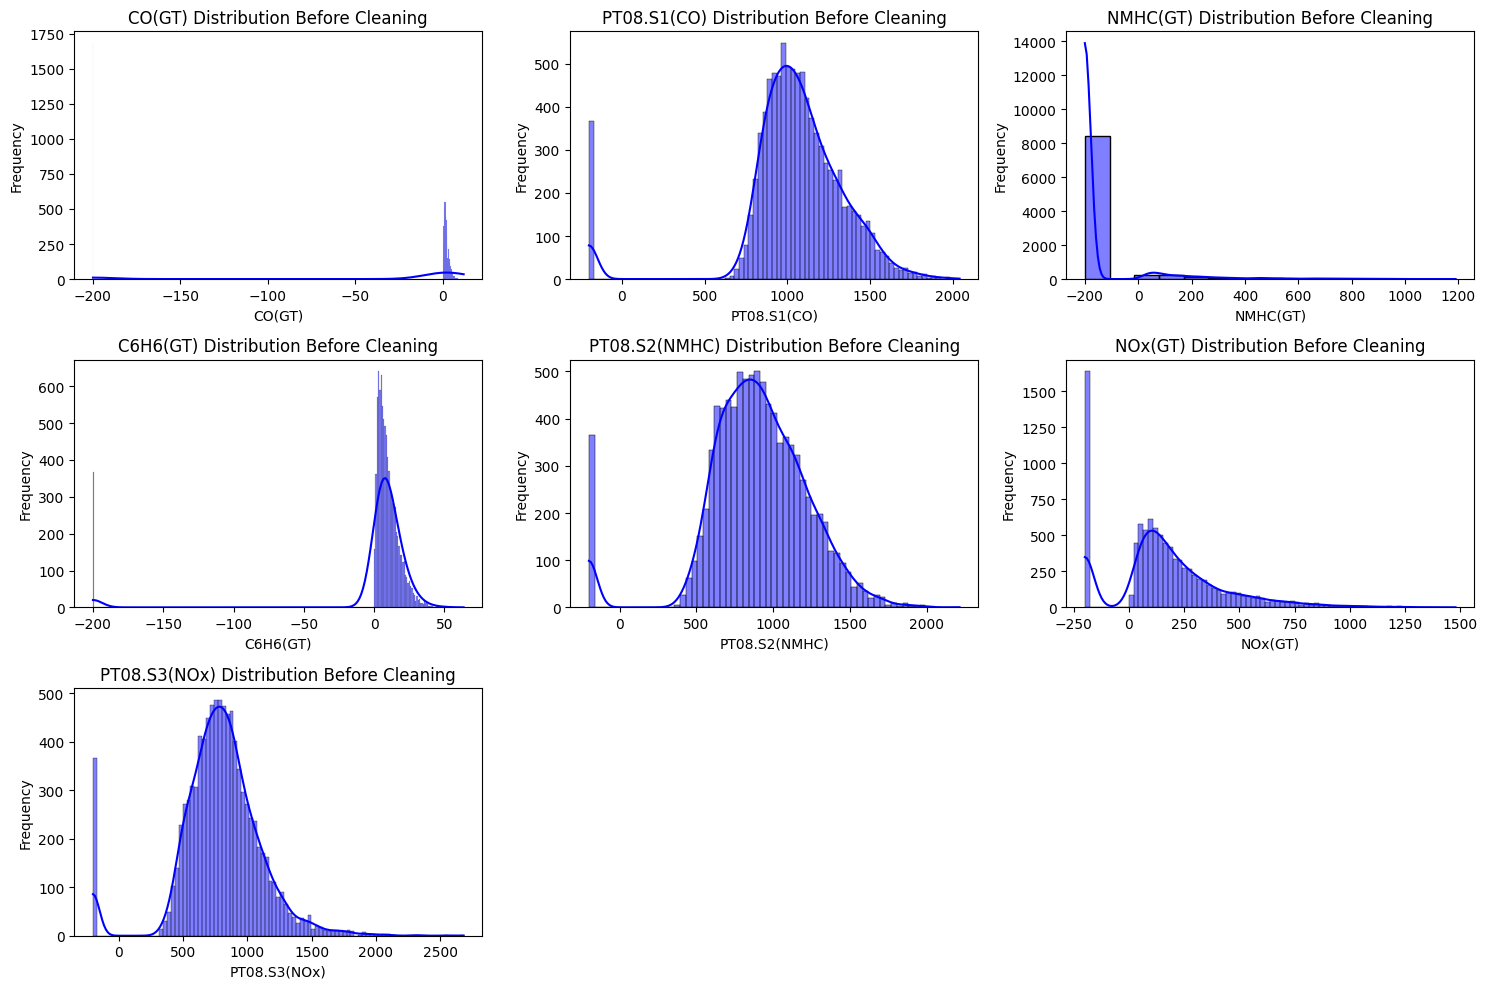

In [5]:
plt.figure(figsize=(15, 10))

# Create subplots for each variable with negative values
variables = ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)']

for i, variable in enumerate(variables):
    plt.subplot(3, 3, i+1)
    sns.histplot(df[variable], kde=True, color='blue')
    plt.title(f'{variable} Distribution Before Cleaning')
    plt.xlabel(variable)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [6]:
for column in variables:
    df[column] = df[column].apply(lambda x: np.nan if x < 0 else x).interpolate()

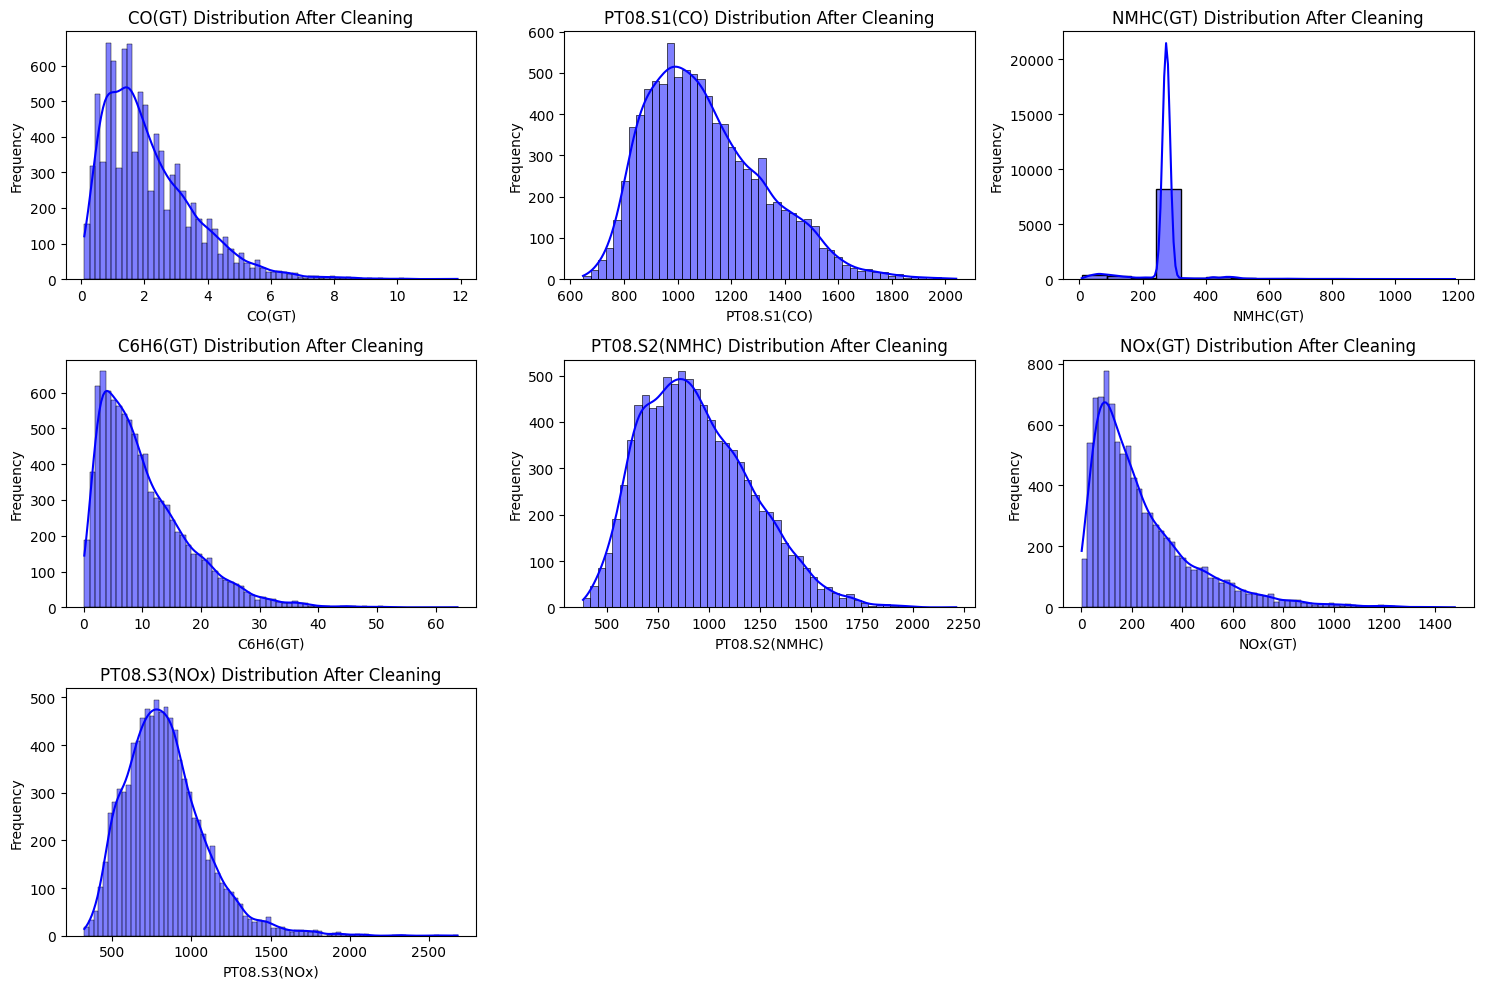

In [7]:
plt.figure(figsize=(15, 10))

# Create subplots for each variable with negative values
variables = ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)']

for i, variable in enumerate(variables):
    plt.subplot(3, 3, i+1)
    sns.histplot(df[variable], kde=True, color='blue')
    plt.title(f'{variable} Distribution After Cleaning')
    plt.xlabel(variable)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [8]:
df.head()

,Date_Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx)
0,10/03/2004 18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0
1,10/03/2004 19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0
2,10/03/2004 20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0
3,10/03/2004 21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0
4,10/03/2004 22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0


In [9]:
# Rename the columns to 'ds' and 'y' before fitting the model
data = df[['Date_Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'NOx(GT)']].copy()  # Create a copy to avoid modifying the original DataFrame
data.rename(columns={'Date_Time': 'ds', 'CO(GT)': 'y'}, inplace=True)

# Convert 'ds' column to datetime with explicit format
data['ds'] = pd.to_datetime(data['ds'], format='%d/%m/%Y %H.%M.%S')

# Fit the Prophet model with the renamed columns and formatted dates
model = Prophet()
# Add the additional regressors (you can choose the relevant ones)
model.add_regressor('PT08.S1(CO)')
model.add_regressor('NMHC(GT)')
model.add_regressor('NOx(GT)')

# Step 3: Fit the model
model.fit(data)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpeao1w6x1/vu35v7vm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpeao1w6x1/7bxrc1gi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78046', 'data', 'file=/tmp/tmpeao1w6x1/vu35v7vm.json', 'init=/tmp/tmpeao1w6x1/7bxrc1gi.json', 'output', 'file=/tmp/tmpeao1w6x1/prophet_model2qcym6r4/prophet_model-20241019154216.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:42:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:42:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [10]:
future = model.make_future_dataframe(periods=365)

future['PT08.S1(CO)'] = df['PT08.S1(CO)'].mean()
future['NMHC(GT)'] = df['NMHC(GT)'].mean()
future['NOx(GT)'] = df['NOx(GT)'].mean()


forecast = model.predict(future)

In [11]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
9717,2006-03-31 14:00:00,2.908464,-11.634896,17.744850
9718,2006-04-01 14:00:00,2.745585,-12.075065,17.840195
9719,2006-04-02 14:00:00,2.784261,-11.817826,17.836182
9720,2006-04-03 14:00:00,2.824695,-11.953035,18.039327
9721,2006-04-04 14:00:00,2.891910,-12.161528,18.173918


In [12]:
from sklearn.metrics import mean_squared_error

forecast_train_filtered = forecast[forecast['ds'].isin(data['ds'])]

# Step 5: Extract actual and predicted values
actual_values = data['y'].values  # Actual CO(GT) values
predicted_values = forecast_train_filtered['yhat'].values  # Filtered predicted values (yhat)

# Step 6: Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 1.4480628273082814


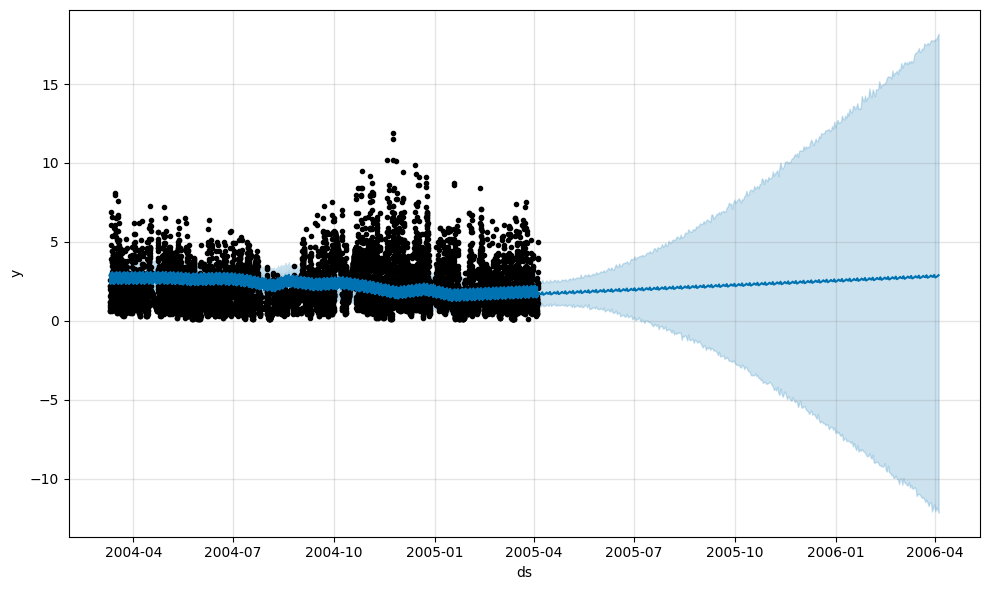

In [13]:
# Python
fig1 = model.plot(forecast)

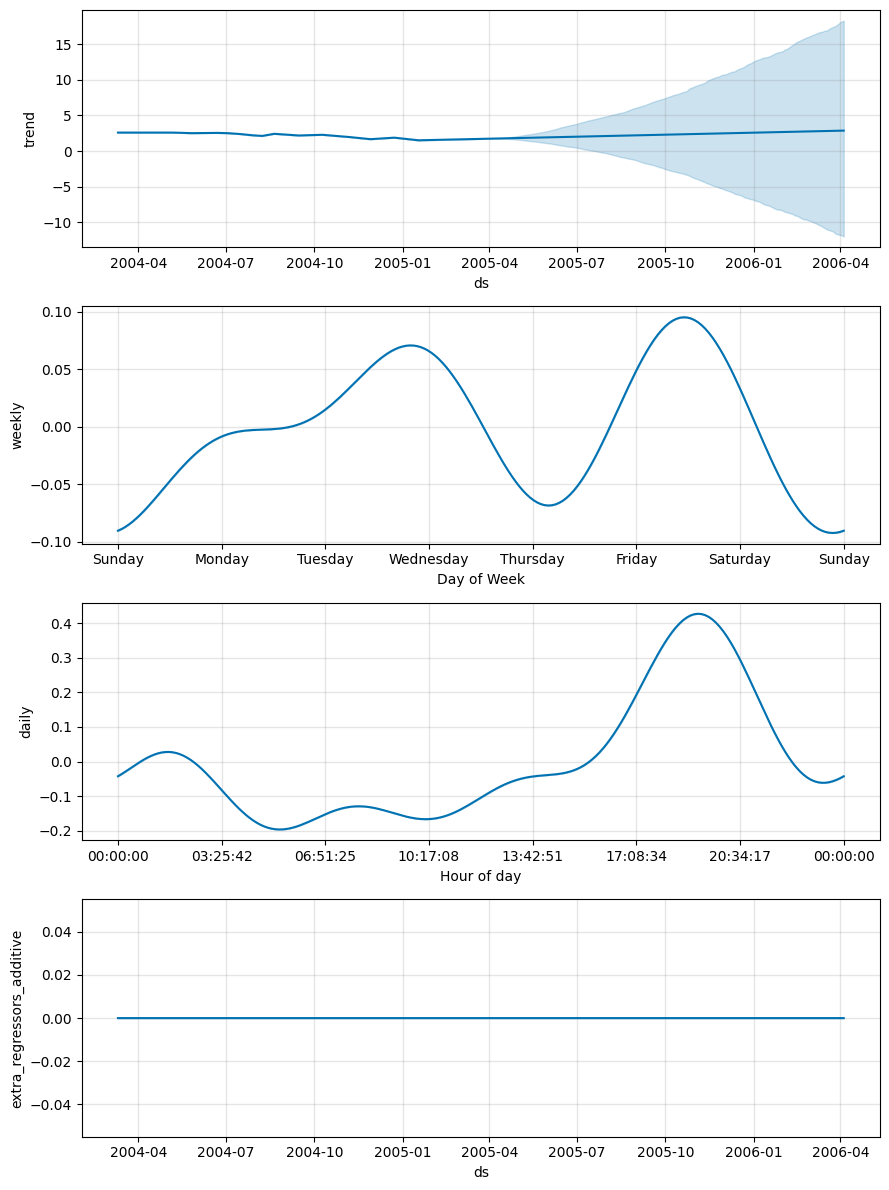

In [15]:
# Python
fig2 = model.plot_components(forecast)